In [ ]:
# Importing necessary libraries for EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

# Importing libraries necessary for Model Building and Training
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
file_path = '/content/Phishing_Email.csv'

In [ ]:
data = pd.read_csv(file_path)
data.head()


,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email


In [ ]:
#check how many such tweets data we have , print the shape of the data frame.
data.shape


(18650, 3)

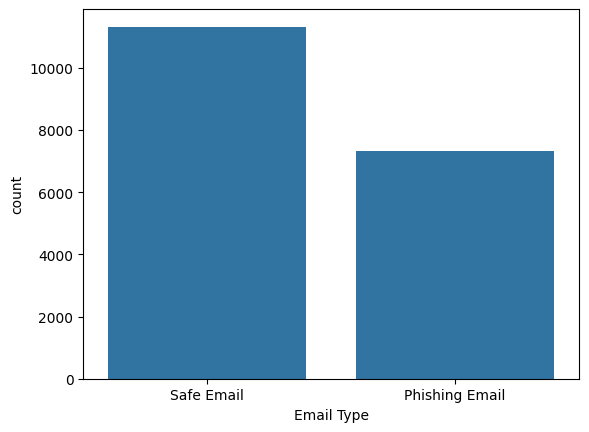

In [ ]:
sns.countplot(x='Email Type', data=data)
plt.show()


**`This data set is imbalanced `**

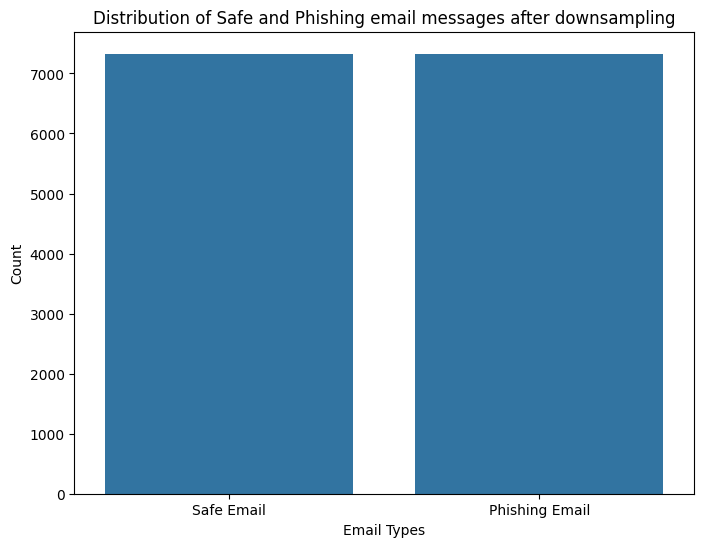

In [ ]:
# Downsampling to balance the dataset
safe_email = data[data['Email Type'] == 'Safe Email']
phishing_email = data[data['Email Type'] == 'Phishing Email']

# Downsampling the 'Safe Email' to have the same number as 'Phishing Email'
safe_email_downsampled = safe_email.sample(n=len(phishing_email), random_state=42)

# Combining the downsampled 'Safe Email' with 'Phishing Email'
balanced_data = pd.concat([safe_email_downsampled, phishing_email]).reset_index(drop=True)

# Plotting the counts of the downsampled dataset
plt.figure(figsize=(8, 6))
sns.countplot(data=balanced_data, x='Email Type')
plt.title('Distribution of Safe and Phishing email messages after downsampling')
plt.xlabel('Email Types')
plt.ylabel('Count')
plt.show()

In [ ]:
# Removing the word 'Subject' from the 'Email Text' column in the balanced_data DataFrame
balanced_data['Email Text'] = balanced_data['Email Text'].str.replace('Subject: ', '', regex=False)

# Displaying the first few rows of the DataFrame to verify changes
balanced_data.head()


,Unnamed: 0,Email Text,Email Type
0,2132,Eirikur said:\n> This incident is an interesti...,Safe Email
1,4702,"hpl noms for june 06 , 2000 ( see attached fil...",Safe Email
2,9938,"On Tue, Aug 13, 2002 at 12:48:18AM +0100, wint...",Safe Email
3,12545,one more . . . http : / / www . cfo . com / ar...,Safe Email
4,15140,use Perl Daily NewsletterIn this issue:\n *...,Safe Email


In [ ]:
import string

# Function to remove punctuations and add handling for non-string inputs
def remove_punctuations(text):
    if isinstance(text, str):
        punctuations_list = string.punctuation
        translator = str.maketrans('', '', punctuations_list)
        return text.translate(translator)
    else:
        return text

# Apply the function to the 'Email Text' column of your DataFrame
balanced_data['Email Text'] = balanced_data['Email Text'].apply(remove_punctuations)
balanced_data.head()


,Unnamed: 0,Email Text,Email Type
0,2132,Eirikur said\n This incident is an interesting...,Safe Email
1,4702,hpl noms for june 06 2000 see attached file ...,Safe Email
2,9938,On Tue Aug 13 2002 at 124818AM 0100 wintermute...,Safe Email
3,12545,one more http www cfo com article ar...,Safe Email
4,15140,use Perl Daily NewsletterIn this issue\n T...,Safe Email


In [ ]:
import nltk
from nltk.corpus import stopwords

# Download the stopwords from NLTK
nltk.download('stopwords')

def remove_stopwords(text):
    # Getting the list of stopwords from NLTK
    stop_words = set(stopwords.words('english'))

    # Splitting the text into words and storing non-stop words
    imp_words = [word.lower() for word in str(text).split() if word.lower() not in stop_words]

    # Joining the important words back into a string
    output = " ".join(imp_words)

    return output

# Applying the function to the 'Email Text' column of your DataFrame
balanced_data['Email Text'] = balanced_data['Email Text'].apply(remove_stopwords)
balanced_data.head()



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Unnamed: 0,Email Text,Email Type
0,2132,eirikur said incident interesting microcosm so...,Safe Email
1,4702,hpl noms june 06 2000 see attached file hplo 6...,Safe Email
2,9938,tue aug 13 2002 124818am 0100 wintermute menti...,Safe Email
3,12545,one http www cfo com article article 6748 stop...,Safe Email
4,15140,use perl daily newsletterin issue week perl5po...,Safe Email


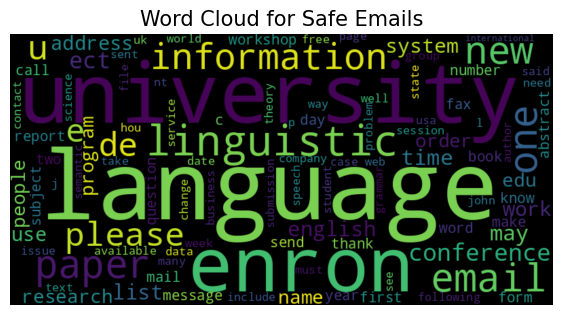

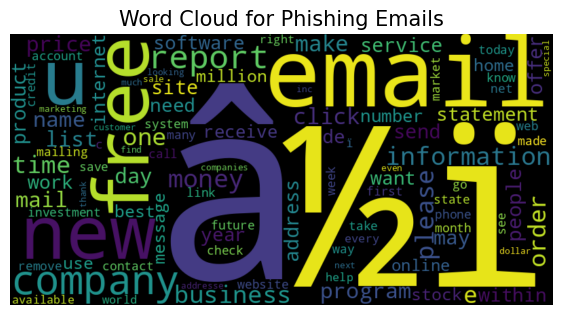

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_word_cloud(data, column, typ):
    email_corpus = " ".join(data[column].astype(str))

    plt.figure(figsize=(7, 7))

    wc = WordCloud(background_color='black',
                   max_words=100,
                   width=800,
                   height=400,
                   collocations=False).generate(email_corpus)

    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'Word Cloud for {typ} Emails', fontsize=15)
    plt.axis('off')
    plt.show()

# Ensure that 'Email Text' and 'Email Type' match your DataFrame's column names
plot_word_cloud(balanced_data[balanced_data['Email Type'] == 'Safe Email'], 'Email Text', 'Safe')
plot_word_cloud(balanced_data[balanced_data['Email Type'] == 'Phishing Email'], 'Email Text', 'Phishing')


In [ ]:
from sklearn.model_selection import train_test_split

# First, you may need to convert your 'Email Type' to a numerical format if it isn't already
balanced_data['label'] = balanced_data['Email Type'].map({'Safe Email': 0, 'Phishing Email': 1})

# Now perform the train-test split
train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['Email Text'],  # Adjusted for your data
                                                    balanced_data['label'],       # Adjusted for your data
                                                    test_size=0.2,
                                                    random_state=42)


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Create a Tokenizer object to tokenize the text data
tokenizer = Tokenizer()

# Fit the tokenizer on the training text data
tokenizer.fit_on_texts(train_X)

# Convert text to sequences of integers
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

# Specify the maximum sequence length
max_len = 100

# Pad the sequences to ensure uniformity of input size
train_sequences = pad_sequences(train_sequences,
                                maxlen=max_len,
                                padding='post',
                                truncating='post')
test_sequences = pad_sequences(test_sequences,
                               maxlen=max_len,
                               padding='post',
                               truncating='post')

# Now train_sequences and test_sequences are ready to be used as input for a machine learning model.


In [ ]:
import tensorflow as tf

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1,
                              output_dim=32,
                              input_length=max_len),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           5126976   
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5130689 (19.57 MB)
Trainable params: 5130689 (19.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',  # You can also use tf.keras.losses.BinaryCrossentropy() without from_logits argument
              metrics=['accuracy'],
              optimizer='adam')


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Setup EarlyStopping
es = EarlyStopping(patience=3,
                   monitor='val_accuracy',
                   restore_best_weights=True)

# Setup ReduceLROnPlateau
lr = ReduceLROnPlateau(patience=2,
                       monitor='val_loss',
                       factor=0.5,
                       verbose=1)  # Change verbose to 1 to see the reductions in the learning rate


In [ ]:
# Train the model
history = model.fit(train_sequences, train_Y,
					validation_data=(test_sequences, test_Y),
					epochs=20,
					batch_size=32,
					callbacks = [lr, es]
				)


Epoch 1/20
367/367 [==============================] - 55s 138ms/step - loss: 0.3835 - accuracy: 0.8304 - val_loss: 0.2798 - val_accuracy: 0.9243 - lr: 0.0010
Epoch 2/20
367/367 [==============================] - 43s 116ms/step - loss: 0.2183 - accuracy: 0.9410 - val_loss: 0.3012 - val_accuracy: 0.9045 - lr: 0.0010
Epoch 3/20
367/367 [==============================] - 42s 113ms/step - loss: 0.2394 - accuracy: 0.9289 - val_loss: 0.2659 - val_accuracy: 0.9229 - lr: 0.0010
Epoch 4/20
367/367 [==============================] - 42s 114ms/step - loss: 0.1855 - accuracy: 0.9492 - val_loss: 0.2506 - val_accuracy: 0.9277 - lr: 0.0010
Epoch 5/20
367/367 [==============================] - 43s 117ms/step - loss: 0.1198 - accuracy: 0.9699 - val_loss: 0.1779 - val_accuracy: 0.9526 - lr: 0.0010
Epoch 6/20
367/367 [==============================] - 44s 120ms/step - loss: 0.1624 - accuracy: 0.9385 - val_loss: 0.1528 - val_accuracy: 0.9430 - lr: 0.0010
Epoch 7/20
367/367 [==============================] 

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)


92/92 [==============================] - 1s 10ms/step - loss: 0.1257 - accuracy: 0.9615
Test Loss : 0.12571203708648682
Test Accuracy : 0.961459755897522


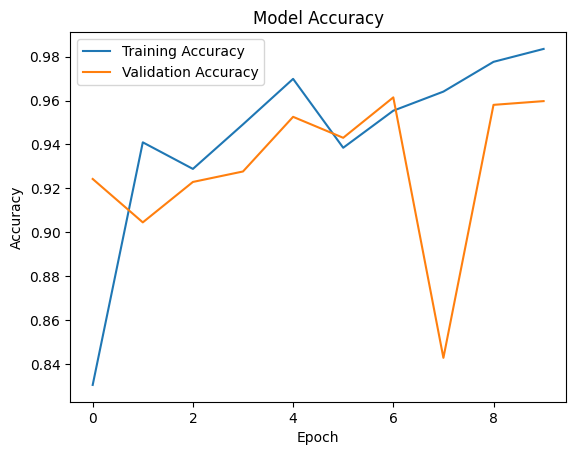

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()
